In [1]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio

import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
from scipy.spatial import KDTree

In [2]:

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the "area" DataFrame

area_data = pd.read_csv("https://github.com/christianhof/BioScen1.5_SDM/raw/master/data/realm_coordinates.csv")
area_latitudes = area_data['y']
area_longitudes = area_data['x']

luh_area = pd.DataFrame()
# Load the land use datasets for SSP126 and SSP460
ncfname_ssp126 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical.nc"
ncfname_ssp460 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp460.nc"
da_landuse_ssp126 = xr.open_dataset(ncfname_ssp126, decode_times=False)
da_landuse_ssp460 = xr.open_dataset(ncfname_ssp460, decode_times=False)

In [3]:

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the "area" DataFrame

area_data = pd.read_csv("https://github.com/christianhof/BioScen1.5_SDM/raw/master/data/realm_coordinates.csv")
area_latitudes = area_data['y']
area_longitudes = area_data['x']

luh_area = pd.DataFrame()
# Load the land use datasets for SSP126 and SSP460
ncfname_ssp126 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126.nc"
ncfname_ssp460 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp460.nc"
da_landuse_ssp126 = xr.open_dataset(ncfname_ssp126, decode_times=False)
da_landuse_ssp460 = xr.open_dataset(ncfname_ssp460, decode_times=False)

luh_area_latitudes = da_landuse_ssp126["lat"].values
luh_area_longitudes = da_landuse_ssp126["lon"].values


# Define the category mapping
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forested land': ['primf', 'secdf'],
    'non-forested land': ['primn', 'secdn']
}

# Get the time values
time_ssp126 = da_landuse_ssp126['time'].values
time_ssp460 = da_landuse_ssp460['time'].values
years_ssp126 = np.arange(2015, 2015 + len(time_ssp126))
years_ssp460 = np.arange(2015, 2015 + len(time_ssp460))


# Create an empty array to store area values
area_values = np.zeros_like(da_landuse_ssp126['primf'].isel(time=0))

# Loop over latitude and longitude indices
for lat_idx, lat in enumerate(da_landuse_ssp126['lat']):
    for lon_idx, lon in enumerate(da_landuse_ssp126['lon']):
        # Find the corresponding area value based on latitude and longitude in area_data
        area_idx = (area_latitudes == lat) & (area_longitudes == lon)
        
        if np.any(area_idx):
            # Get the area value for this grid cell
            area_per_cell = area_data.loc[area_idx, 'area'].values[0]
            # Set the area value in the area_values array
            area_values[lat_idx, lon_idx] = area_per_cell

# Add the "area" variable to the da_landuse_ssp126 dataset
da_landuse_ssp126["area"] = xr.DataArray(area_values, dims=("lat", "lon"), coords={"lat": da_landuse_ssp126['lat'], "lon": da_landuse_ssp126['lon']})

# Initialize the modified land use datasets
modified_landuse_ssp126 = da_landuse_ssp126.copy()


# Loop over the data variables and convert the values to Mkm² for SSP126
for variable in da_landuse_ssp126.data_vars:
    
    # Assign the converted values to the modified_landuse_ssp126 dataset
    modified_landuse_ssp126[variable] = da_landuse_ssp126["area"] * da_landuse_ssp126[variable]  / 1e6


# Create an empty array to store area values
area_values = np.zeros_like(da_landuse_ssp460['primf'].isel(time=0))

# Loop over latitude and longitude indices
for lat_idx, lat in enumerate(da_landuse_ssp460['lat']):
    for lon_idx, lon in enumerate(da_landuse_ssp460['lon']):
        # Find the corresponding area value based on latitude and longitude in area_data
        area_idx = (area_latitudes == lat) & (area_longitudes == lon)
        
        if np.any(area_idx):
            # Get the area value for this grid cell
            area_per_cell = area_data.loc[area_idx, 'area'].values[0]
            # Set the area value in the area_values array
            area_values[lat_idx, lon_idx] = area_per_cell

# Add the "area" variable to the da_landuse_ssp126 dataset
da_landuse_ssp460["area"] = xr.DataArray(area_values, dims=("lat", "lon"), coords={"lat": da_landuse_ssp460['lat'], "lon": da_landuse_ssp460['lon']})

modified_landuse_ssp460 = da_landuse_ssp460.copy()
for variable in da_landuse_ssp460.data_vars:
    
    # Assign the converted values to the modified_landuse_ssp126 dataset
    modified_landuse_ssp460[variable] = da_landuse_ssp460["area"] * da_landuse_ssp460[variable]  / 1e6

ValueError: dimensions () must have the same length as the number of data dimensions, ndim=1

In [4]:



# Calculate the sum of values for each variable for SSP126
sum_over_values_ssp126 = modified_landuse_ssp126.sum(dim=[dim for dim in modified_landuse_ssp126.dims if dim != 'time'])

# Calculate the sum of values for each variable for SSP460
sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

# Calculate the difference to Year 0 for each variable for SSP126
difference_ssp126 = sum_over_values_ssp126 - sum_over_values_ssp126.isel(time=0)

# Create a new dataset for sum over categories for SSP126
sum_over_categories_ssp126 = xr.Dataset()

# Sum the differences for cropland category for SSP126
sum_over_categories_ssp126['cropland'] = sum_over_values_ssp126['c3ann'] + sum_over_values_ssp126['c3per'] + sum_over_values_ssp126['c4ann'] + sum_over_values_ssp126['c4per'] + sum_over_values_ssp126['c3nfx']

# Sum the differences for pasture category for SSP126
sum_over_categories_ssp126['pasture'] = sum_over_values_ssp126['pastr'] + sum_over_values_ssp126['range']

# Sum the differences for forest category for SSP126
sum_over_categories_ssp126['forested land'] = sum_over_values_ssp126['primf'] + sum_over_values_ssp126['secdf']

# Sum the differences for natural_land category for SSP126
sum_over_categories_ssp126['non-forested land'] = sum_over_values_ssp126['primn'] + sum_over_values_ssp126['secdn']

# Calculate the difference to Year 0 for each category for SSP126
difference_ssp126 = sum_over_categories_ssp126 - sum_over_categories_ssp126.isel(time=0)


# Calculate the sum of values for each variable for SSP460
sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

# Create a new dataset for sum over categories for SSP460
sum_over_categories_ssp460 = xr.Dataset()

# Sum the differences for cropland category for SSP460
sum_over_categories_ssp460['cropland'] = sum_over_values_ssp460['c3ann'] + sum_over_values_ssp460['c3per'] + sum_over_values_ssp460['c4ann'] + sum_over_values_ssp460['c4per'] + sum_over_values_ssp460['c3nfx']

# Sum the differences for pasture category for SSP460
sum_over_categories_ssp460['pasture'] = sum_over_values_ssp460['pastr'] + sum_over_values_ssp460['range']

# Sum the differences for forest category for SSP460
sum_over_categories_ssp460['forested land'] = sum_over_values_ssp460['primf'] + sum_over_values_ssp460['secdf']

# Sum the differences for natural_land category for SSP460
sum_over_categories_ssp460['non-forested land'] = sum_over_values_ssp460['primn'] + sum_over_values_ssp460['secdn']

# Calculate the difference to Year 0 for each category for SSP460
difference_ssp460 = sum_over_categories_ssp460 - sum_over_categories_ssp460.isel(time=0)


# Set the category colors
category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forested land': '#000080',
    'non-forested land': 'red'
}


# Create a figure and axes for SSP126
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot SSP126 data
for category in category_mapping:
    values_ssp126 = difference_ssp126[category].values
    ax1.plot(years_ssp126, values_ssp126, label=category, color=category_colors[category])

ax1.axhline(y=0.0, color='grey', linestyle='--')
ax1.set_xlabel('Years')
ax1.set_ylabel('Change in Land Area from 2015 (Mkm²)')
ax1.set_ylim(-10, 10)
ax1.legend()
ax1.set_title("SSP126")


# Plot SSP460 data
for category in category_mapping:
    values_ssp460 = difference_ssp460[category].values
    ax2.plot(years_ssp460, values_ssp460, label=category, color=category_colors[category])

ax2.axhline(y=0.0, color='grey', linestyle='--')
ax2.set_xlabel('Years')
ax2.set_ylabel('Change in Land Area from 2015 (Mkm²)')
ax2.set_ylim(-10, 10)
ax2.legend()
ax2.set_title("SSP460")


# Add a suptitle
fig.suptitle("Comparison of Land Area Change between SSP126 and SSP460")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
#plt.show()
plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_1")


NameError: name 'modified_landuse_ssp126' is not defined

Difference to 1995


In [5]:
# Convert area_latitudes and area_longitudes to numpy arrays and check their data type
area_latitudes = np.array(area_latitudes, dtype=np.float64)
area_longitudes = np.array(area_longitudes, dtype=np.float64)

# Convert lat and lon from xarray to numpy arrays for compatibility
latitudes = da_landuse_historic['lat'].values.astype(np.float64)
longitudes = da_landuse_historic['lon'].values.astype(np.float64)

# Check if all data types are now compatible
print("Area latitudes type:", area_latitudes.dtype)
print("Area longitudes type:", area_longitudes.dtype)
print("Dataset latitudes type:", latitudes.dtype)
print("Dataset longitudes type:", longitudes.dtype)


NameError: name 'da_landuse_historic' is not defined

In [6]:
### try 1995 as comparison instead of 2015

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the "area" DataFrame

area_data = pd.read_csv("https://github.com/christianhof/BioScen1.5_SDM/raw/master/data/realm_coordinates.csv")
area_latitudes = area_data['y']
area_longitudes = area_data['x']

luh_area = pd.DataFrame()
# Load the land use datasets for SSP126 and SSP460
ncfname_ssp126 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126.nc"
ncfname_ssp460 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp460.nc"
ncfname_historic = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical.nc"
da_landuse_ssp126 = xr.open_dataset(ncfname_ssp126, decode_times=False)
da_landuse_ssp460 = xr.open_dataset(ncfname_ssp460, decode_times=False)
da_landuse_historic = xr.open_dataset(ncfname_historic, decode_times=False)

luh_area_latitudes = da_landuse_ssp126["lat"].values
luh_area_longitudes = da_landuse_ssp126["lon"].values


# Define the category mapping
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forested land': ['primf', 'secdf'],
    'non-forested land': ['primn', 'secdn']
}

# Get the time values
time_ssp126 = da_landuse_ssp126['time'].values
time_ssp460 = da_landuse_ssp460['time'].values
time_historic = da_landuse_historic['time'].values
years_ssp126 = np.arange(2015, 2015 + len(time_ssp126))
years_ssp460 = np.arange(2015, 2015 + len(time_ssp460))
years_historic = np.arange(850 +  len(time_historic))


area_coords = np.array(list(zip(area_latitudes, area_longitudes)))
tree = KDTree(area_coords)

# Prepare array to hold area values for each (lat, lon) in da_landuse_historic
latitudes = da_landuse_historic['lat'].values
longitudes = da_landuse_historic['lon'].values
area_values = np.zeros((len(latitudes), len(longitudes)))

# Assign area values based on nearest neighbors
for lat_idx, lat in enumerate(latitudes):
    for lon_idx, lon in enumerate(longitudes):
        # Find the nearest (lat, lon) in area_data using KDTree
        _, nearest_idx = tree.query([lat, lon])
        # Assign area value based on nearest match
        area_values[lat_idx, lon_idx] = area_data['area'].iloc[nearest_idx]

# Add area data to da_landuse_historic
da_landuse_historic["area"] = xr.DataArray(area_values, dims=("lat", "lon"), coords={"lat": latitudes, "lon": longitudes})


# Initialize the modified land use datasets
modified_landuse_historic = da_landuse_historic.copy()


# Loop over the data variables and convert the values to Mkm² for SSP126
for variable in da_landuse_historic.data_vars:
    
    # Assign the converted values to the modified_landuse_ssp126 dataset
    modified_landuse_historic[variable] = da_landuse_historic["area"] * da_landuse_historic[variable]  / 1e6
    

# Create an empty array to store area values
#area_values = np.zeros_like(da_landuse_ssp126['primf'].isel(time=0))

# Prepare array to hold area values for each (lat, lon) in da_landuse_historic
latitudes = da_landuse_ssp126['lat'].values
longitudes = da_landuse_ssp126['lon'].values
area_values = np.zeros((len(latitudes), len(longitudes)))

# Assign area values based on nearest neighbors
for lat_idx, lat in enumerate(latitudes):
    for lon_idx, lon in enumerate(longitudes):
        # Find the nearest (lat, lon) in area_data using KDTree
        _, nearest_idx = tree.query([lat, lon])
        # Assign area value based on nearest match
        area_values[lat_idx, lon_idx] = area_data['area'].iloc[nearest_idx]

# Add area data to da_landuse_historic
da_landuse_ssp126["area"] = xr.DataArray(area_values, dims=("lat", "lon"), coords={"lat": latitudes, "lon": longitudes})


# Initialize the modified land use datasets
modified_landuse_ssp126 = da_landuse_ssp126.copy()


# Loop over the data variables and convert the values to Mkm² for SSP126
for variable in da_landuse_ssp126.data_vars:
    
    # Assign the converted values to the modified_landuse_ssp126 dataset
    modified_landuse_ssp126[variable] = da_landuse_ssp126["area"] * da_landuse_ssp126[variable]  / 1e6

    

# Loop over latitude and longitude indices
latitudes = da_landuse_ssp460['lat'].values
longitudes = da_landuse_ssp460['lon'].values
area_values = np.zeros((len(latitudes), len(longitudes)))

# Assign area values based on nearest neighbors
for lat_idx, lat in enumerate(latitudes):
    for lon_idx, lon in enumerate(longitudes):
        # Find the nearest (lat, lon) in area_data using KDTree
        _, nearest_idx = tree.query([lat, lon])
        # Assign area value based on nearest match
        area_values[lat_idx, lon_idx] = area_data['area'].iloc[nearest_idx]

# Add area data to da_landuse_historic
da_landuse_ssp460["area"] = xr.DataArray(area_values, dims=("lat", "lon"), coords={"lat": latitudes, "lon": longitudes})

modified_landuse_ssp460 = da_landuse_ssp460.copy()
for variable in da_landuse_ssp460.data_vars:
    
    # Assign the converted values to the modified_landuse_ssp126 dataset
    modified_landuse_ssp460[variable] = da_landuse_ssp460["area"] * da_landuse_ssp460[variable]  / 1e6

In [7]:


# Calculate the sum of values for each variable for SSP126
sum_over_values_ssp126 = modified_landuse_ssp126.sum(dim=[dim for dim in modified_landuse_ssp126.dims if dim != 'time'])

# Calculate the sum of values for each variable for SSP460
sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

# Calculate the difference to Year 0 for each variable for SSP126
difference_ssp126 = sum_over_values_ssp126 - sum_over_values_ssp126.isel(time=0)

# Create a new dataset for sum over categories for SSP126
sum_over_categories_ssp126 = xr.Dataset()

# Sum the differences for cropland category for SSP126
sum_over_categories_ssp126['cropland'] = sum_over_values_ssp126['c3ann'] + sum_over_values_ssp126['c3per'] + sum_over_values_ssp126['c4ann'] + sum_over_values_ssp126['c4per'] + sum_over_values_ssp126['c3nfx']

# Sum the differences for pasture category for SSP126
sum_over_categories_ssp126['pasture'] = sum_over_values_ssp126['pastr'] + sum_over_values_ssp126['range']

# Sum the differences for forest category for SSP126
sum_over_categories_ssp126['forested land'] = sum_over_values_ssp126['primf'] + sum_over_values_ssp126['secdf']

# Sum the differences for natural_land category for SSP126
sum_over_categories_ssp126['non-forested land'] = sum_over_values_ssp126['primn'] + sum_over_values_ssp126['secdn']

# Calculate the difference to Year 0 for each category for SSP126
#difference_ssp126 = sum_over_categories_ssp126 - sum_over_categories_ssp126.isel(time=0)


# Calculate the sum of values for each variable for SSP460
sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

# Create a new dataset for sum over categories for SSP460
sum_over_categories_ssp460 = xr.Dataset()

# Sum the differences for cropland category for SSP460
sum_over_categories_ssp460['cropland'] = sum_over_values_ssp460['c3ann'] + sum_over_values_ssp460['c3per'] + sum_over_values_ssp460['c4ann'] + sum_over_values_ssp460['c4per'] + sum_over_values_ssp460['c3nfx']

# Sum the differences for pasture category for SSP460
sum_over_categories_ssp460['pasture'] = sum_over_values_ssp460['pastr'] + sum_over_values_ssp460['range']

# Sum the differences for forest category for SSP460
sum_over_categories_ssp460['forested land'] = sum_over_values_ssp460['primf'] + sum_over_values_ssp460['secdf']

# Sum the differences for natural_land category for SSP460
sum_over_categories_ssp460['non-forested land'] = sum_over_values_ssp460['primn'] + sum_over_values_ssp460['secdn']

# Calculate the difference to Year 0 for each category for SSP460
#difference_ssp460 = sum_over_categories_ssp460 - sum_over_categories_ssp460.isel(time=0)



# Calculate the sum of values for each variable for SSP126
sum_over_values_historic = modified_landuse_historic.sum(dim=[dim for dim in modified_landuse_historic.dims if dim != 'time'])


# Calculate the difference to Year 0 for each variable for SSP126
difference_ssp126 = sum_over_values_ssp126 - sum_over_values_historic.isel(time=1146)



# Create a new dataset for sum over categories for SSP126
sum_over_categories_historic = xr.Dataset()

# Sum the differences for cropland category for SSP126
sum_over_categories_historic['cropland'] = sum_over_values_historic['c3ann'] + sum_over_values_historic['c3per'] + sum_over_values_historic['c4ann'] + sum_over_values_historic['c4per'] + sum_over_values_historic['c3nfx']

# Sum the differences for pasture category for SSP126
sum_over_categories_historic['pasture'] = sum_over_values_historic['pastr'] + sum_over_values_historic['range']

# Sum the differences for forest category for SSP126
sum_over_categories_historic['forested land'] = sum_over_values_historic['primf'] + sum_over_values_historic['secdf']

# Sum the differences for natural_land category for SSP126
sum_over_categories_historic['non-forested land'] = sum_over_values_historic['primn'] + sum_over_values_historic['secdn']

# Calculate the difference to Year 0 for each category for SSP126
difference_ssp126 = sum_over_categories_ssp126 - sum_over_categories_historic.isel(time=1146) 
    
difference_ssp460 = sum_over_categories_ssp460 - sum_over_categories_historic.isel(time=1146)



In [8]:
years_historic = np.array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

# Create an array of years from 1995 to 2100
years_ssp460 = np.arange(2016, 2101)

# Concatenate the two arrays to get the final array
all_years = np.concatenate((years_historic, years_ssp460))

print(all_years)


[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036
 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050
 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064
 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078
 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092
 2093 2094 2095 2096 2097 2098 2099 2100]


In [9]:
sum_over_categories_historic_sliced = sum_over_categories_historic.isel(time=slice(1146, None))
sum_combined_ssp126  = xr.concat([sum_over_categories_historic_sliced, sum_over_categories_ssp126], dim="time")
difference_ssp126 = sum_combined_ssp126 - sum_over_categories_historic.isel(time=1146) 

sum_combined_ssp460  = xr.concat([sum_over_categories_historic_sliced, sum_over_categories_ssp460], dim="time")
difference_ssp460= sum_combined_ssp460 - sum_over_categories_historic.isel(time=1146) 

In [10]:
all_years

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049,
       2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060,
       2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071,
       2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082,
       2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093,
       2094, 2095, 2096, 2097, 2098, 2099, 2100])

In [11]:
import matplotlib as mpl
def set_plot_param():

    """Set my own customized plotting parameters"""

    import matplotlib as mpl

    mpl.rc('axes',edgecolor='grey')

    mpl.rc('axes',labelcolor='black')

    mpl.rc('xtick',color='black')

    mpl.rc('xtick',labelsize=14)

    mpl.rc('ytick',color='black')

    mpl.rc('ytick',labelsize=14)

    mpl.rc('axes',titlesize=18)

    mpl.rc('axes',labelsize=14)

    mpl.rc('legend',fontsize='large')

    mpl.rc('text',color='black')
    

    

In [12]:
def set_plot_param():

    mpl.rc('axes',edgecolor='grey')
    mpl.rc('axes',labelcolor='dimgrey')
    mpl.rc('xtick',color='dimgrey')
    mpl.rc('xtick',labelsize=12)
    mpl.rc('ytick',color='dimgrey')
    mpl.rc('ytick',labelsize=12)
    mpl.rc('axes',titlesize=14)
    mpl.rc('axes',labelsize=12)
    mpl.rc('legend',fontsize='large')
    mpl.rc('text',color='dimgrey')

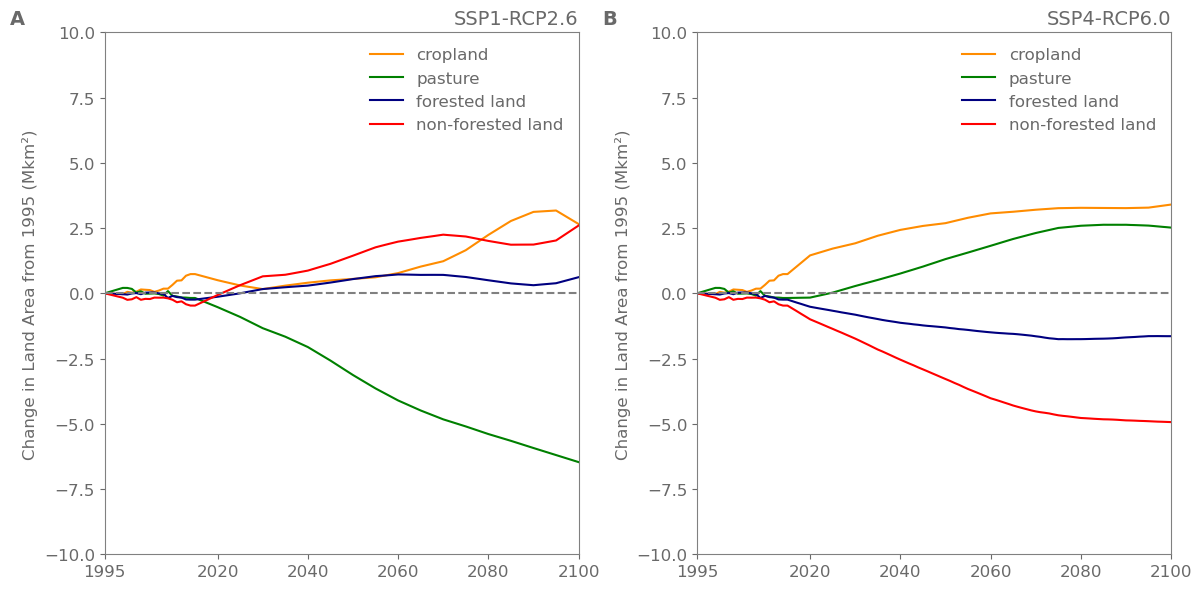

In [13]:
set_plot_param()
labels=["A","B"]

# Set the category colors
category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forested land': '#000080',
    'non-forested land': 'red'
}


# Create a figure and axes for SSP126
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot SSP126 data
for category in category_mapping:
    values_ssp126 = difference_ssp126[category].values
    ax1.plot(all_years, values_ssp126, label=category, color=category_colors[category])

ax1.axhline(y=0.0, color='grey', linestyle='--')
#ax1.set_xlabel('Years')
ax1.set_ylabel('Change in Land Area from 1995 (Mkm²)')
ax1.set_ylim(-10, 10)
ax1.set_title(labels[0],loc='left', x=-0.2, weight='bold')
#ax1.legend()
ax1.legend(framealpha=0.0)  # Set framealpha to make the legend box transparent in ax1

years=(1995,2020,2040,2060,2080,2100)
ax1.set_xticks(years)
ax1.set_xticklabels(years)
ax1.set_xlim(1995, max(all_years))
  # Set framealpha to make the legend box transparent in ax2

ax1.set_title("SSP1-RCP2.6", loc="right")


# Plot SSP460 data
for category in category_mapping:
    values_ssp460 = difference_ssp460[category].values
    ax2.plot(all_years, values_ssp460, label=category, color=category_colors[category])

ax2.axhline(y=0.0, color='grey', linestyle='--')
#ax2.set_xlabel('Years')
ax2.set_ylabel('Change in Land Area from 1995 (Mkm²)')
ax2.set_ylim(-10, 10)
#ax2.legend()
ax2.legend(framealpha=0.0)
ax2.set_title(labels[1],loc='left', x=-0.2, weight='bold')
ax2.set_title("SSP4-RCP6.0", loc="right")
ax1.set_xlim(1995, max(all_years))

years=(1995,2020,2040,2060,2080,2100)
ax2.set_xticks(years)
ax2.set_xticklabels(years)
ax2.set_xlim(1995, max(all_years))
#fig.suptitle("Comparison of Land Area Change between SSP126 and SSP460")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
#plt.show()
plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_1")


In [17]:
def set_plot_param():

    mpl.rc('axes',edgecolor='black')
    mpl.rc('axes',labelcolor='black')
    mpl.rc('xtick',color='black')
    mpl.rc('xtick',labelsize=12)
    mpl.rc('ytick',color='black')
    mpl.rc('ytick',labelsize=12)
    mpl.rc('axes',titlesize=14)
    mpl.rc('axes',labelsize=12)
    mpl.rc('legend',fontsize='large')
    mpl.rc('text',color='black')

/scratch/local/16558674/ipykernel_1960429/2576698995.py:116: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


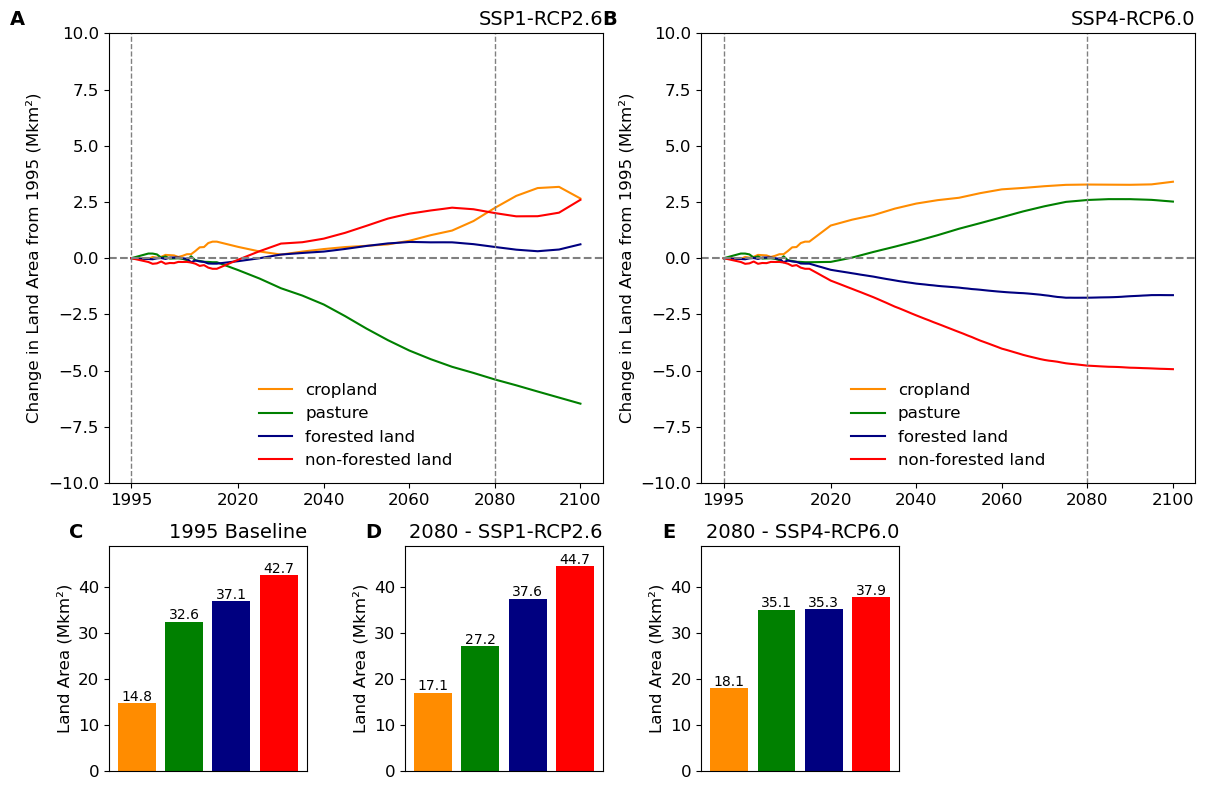

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `difference_ssp126` and `difference_ssp460` contain xarray DataArrays for SSP126 and SSP460 data
set_plot_param()
labels = ["A", "B","C","D","E","F"]

# Define category colors
category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forested land': '#000080',
    'non-forested land': 'red'
}

# Set a consistent y-axis limit for all bar plots
y_axis_limit = 49  # Adjust this value based on the range of your data

# Create figure with a 2x3 grid layout with equal spacing and rotation on x-axis labels
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = fig.add_gridspec(2, 4, height_ratios=[2, 1])

# Line plot for SSP126, spanning 1.5 columns on the left
ax1 = fig.add_subplot(gs[0, :2])
for category in category_mapping.keys():
    values_ssp126 = difference_ssp126[category].values
    ax1.plot(all_years, values_ssp126, label=category, color=category_colors[category])

ax1.axhline(0, color='grey', linestyle='--')
ax1.set_ylabel('Change in Land Area from 1995 (Mkm²)')
ax1.set_ylim(-10, 10)
ax1.set_title("SSP1-RCP2.6", loc="right")
ax1.legend(framealpha=0.0)
ax1.set_title(labels[0],loc='left', x=-0.2, weight='bold')
ax1.set_xticks([1995, 2020, 2040, 2060, 2080, 2100])

# Line plot for SSP460, spanning 1.5 columns on the right
ax2 = fig.add_subplot(gs[0, 2:])
for category in category_mapping.keys():
    values_ssp460 = difference_ssp460[category].values
    ax2.plot(all_years, values_ssp460, label=category, color=category_colors[category])

ax2.axhline(0, color='grey', linestyle='--')
ax2.set_ylabel('Change in Land Area from 1995 (Mkm²)')
ax2.set_ylim(-10, 10)
ax2.set_title("SSP4-RCP6.0", loc="right")
ax2.legend(framealpha=0.0)
ax2.set_title(labels[1],loc='left', x=-0.2, weight='bold')
ax2.set_xticks([1995, 2020, 2040, 2060, 2080, 2100])

# Bar plot for 1995 baseline in the bottom left with rotated x labels and consistent y-axis
ax3 = fig.add_subplot(gs[1, 0])
values_1995_historic = [
    sum_over_categories_historic[category].isel(time=1146).values for category in category_mapping
]
ax3.bar(category_mapping.keys(), values_1995_historic, color=[category_colors[cat] for cat in category_mapping])
ax3.set_ylabel('Land Area (Mkm²)')
ax3.set_title("1995 Baseline", loc="right")
ax3.tick_params(axis='x', rotation=45)
ax3.set_title(labels[2],loc='left', x=-0.2, weight='bold')
ax3.set_ylim(0, y_axis_limit)  # Apply consistent y-axis limit

# Bar plot for 2080 under SSP126 in the bottom center with rotated x labels and consistent y-axis
ax4 = fig.add_subplot(gs[1, 1])
values_2080_ssp126 = [
    sum_over_categories_ssp126[category].isel(time=65).values for category in category_mapping
]
ax4.bar(category_mapping.keys(), values_2080_ssp126, color=[category_colors[cat] for cat in category_mapping])
ax4.set_ylabel('Land Area (Mkm²)')
ax4.set_title("2080 - SSP1-RCP2.6", loc="right")
ax4.tick_params(axis='x', rotation=45)
ax4.set_title(labels[3],loc='left', x=-0.2, weight='bold')
ax4.set_ylim(0, y_axis_limit)  # Apply consistent y-axis limit

# Bar plot for 2080 under SSP460 in the bottom right with rotated x labels and consistent y-axis
ax5 = fig.add_subplot(gs[1, 2])
values_2080_ssp460 = [
    sum_over_categories_ssp460[category].isel(time=65).values for category in category_mapping
]
ax5.bar(category_mapping.keys(), values_2080_ssp460, color=[category_colors[cat] for cat in category_mapping])
ax5.set_ylabel('Land Area (Mkm²)')
ax5.set_title("2080 - SSP4-RCP6.0", loc="right")
ax5.tick_params(axis='x', rotation=45)
ax5.set_title(labels[4],loc='left', x=-.20, weight='bold')
ax5.set_ylim(0, y_axis_limit)  # Apply consistent y-axis limit

# Remove unused last subplot in bottom row to center-align bar plots
ax6 = fig.add_subplot(gs[1, 3])
ax6.axis("off")

ax1.axvline(1995, color='grey', linestyle='--', linewidth=1)  # For SSP126 plot
ax2.axvline(1995, color='grey', linestyle='--', linewidth=1)  # For SSP460 plot


ax1.axvline(2080, color='grey', linestyle='--', linewidth=1)  # For SSP126 plot
ax2.axvline(2080, color='grey', linestyle='--', linewidth=1)  # For SSP460 plot$

# Add values on top of bars in the 1995 Baseline bar plot
for i, v in enumerate(values_1995_historic):
    ax3.text(i, v + 0.5, f"{v:.1f}", ha='center')

# Add values on top of bars in the 2080 SSP126 bar plot
for i, v in enumerate(values_2080_ssp126):
    ax4.text(i, v + 0.5, f"{v:.1f}", ha='center')

# Add values on top of bars in the 2080 SSP460 bar plot
for i, v in enumerate(values_2080_ssp460):
    ax5.text(i, v + 0.5, f"{v:.1f}", ha='center')


ax3.set_xticks([])  # Remove x-axis ticks for 1995 Baseline (label C)
ax4.set_xticks([])  # Remove x-axis ticks for 2080 SSP126 (label D)
ax5.set_xticks([])  # Remove x-axis ticks for 2080 SSP460 (label E)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig("/storage/homefs/ch21o450/scripts/all_figures/Fig.2.2.png", dpi=300, bbox_inches='tight')

# plt.show()
